In [1]:
take = 555

# Description

Script to run the agent on the hardware

0. Description
1. Imports
2. Paths
3. Configuration
4. Functions
5. Creation
6. Run on Hardware
7. Save recorded Data


# Specification

In [2]:
control_rate = 25 #Hz
dt = 0.1
model_number = 999
max_limit = 0.0002 #0.0001 0.000085
R1 = 1
R2 = 0.005
R_success = 250
reality_distance_threshold = 0.0075

reality_horizon = 3000

# Imports

In [3]:
# General imports
import os
import time
import datetime
from os.path import expanduser
import pandas
import pickle
import json
import numpy
from matplotlib import pyplot as plt

# rllib imports
import ray
import ray.rllib.agents.ppo as ppo
from ray.tune.registry import get_trainable_cls
from ray.tune.registry import register_env
from ray.rllib.env import MultiAgentEnv
from ray.rllib.env.base_env import _DUMMY_AGENT_ID
from ray.rllib.evaluation.worker_set import WorkerSet
from ray.rllib.policy.sample_batch import DEFAULT_POLICY_ID
from ray.rllib.utils.deprecation import deprecation_warning

# Gym imports
from gym.envs.robotics.ur10 import randomize
from gym.envs.robotics.ur10 import pos_randomize
from gym.envs.robotics import ur10_noisy_pd_env_mh
from gym.envs.robotics import ur10_sim2real_pos_env
from gym import utils
from gym.envs.robotics import rotations, robot_custom_env_mh, utils
from gym.envs.robotics import ur10_force_env_3
from gym.envs.robotics import ur10_force_env

# MuJoCo imports
import mujoco_py

# ROS imports
import rospy
from sensor_msgs.msg import JointState
from std_msgs.msg import Float64MultiArray
from std_msgs.msg import String
from geometry_msgs.msg import WrenchStamped
from trajectory_msgs.msg import JointTrajectory, JointTrajectoryPoint
from realsense2_camera.msg import CustomVector
from realsense2_camera.msg import EstimatedPose

In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

# Paths

In [4]:
HOME_PATH = os.getenv("HOME")
PROJECT_PATH = os.path.join(*[HOME_PATH, "DRL_AI4RoMoCo"])
SAVE_PATH = os.path.join(*[PROJECT_PATH, "code", "data","TEST_Reality"])

#XML_MODEL_PATH = os.path.join(*[HOME_PATH, "DRL_AI4RoMoCo", "code", "environment","UR10_single","ur10_heg.xml"])   #Force
XML_MODEL_PATH = os.path.join(*[HOME_PATH, "DRL_AI4RoMoCo", "code", "environment","UR10_single_position","ur10_heg_position.xml"])   #Position

env_config = "reality_config_force.yml"
#checkpoint_number = 4950
#model = "PPO_NoisyPositionEnv_0_2020-09-18_20-14-55ej_cw9mo"
control_type = env_config.split("_")[2].split(".")[0]

ENV_CONFIG = os.path.join(*[HOME_PATH, "AGENT_TESTS", env_config])
#ENV_CONFIG = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_ForceEnv_0_2020-09-10_15-29-51_j1bhegb", config])

# Configuration

Hardware - Environment (ROS)

In [5]:
actual_q = numpy.zeros(6,)
ft_values = numpy.zeros(6,)

Simulation - Environment (MuJoCo, Gym)

In [6]:
goal = numpy.array([0.69423743, -0.83110109,  1.17388998, -1.57161506,  0.02185773, -3.14102438])
reward_type = "dense"
distance_threshold = 0.002
fail_threshold = 0.25
punish_force = False
punish_force_thresh = 20
punish_force_factor = 0.001
print(goal)

[ 0.69423743 -0.83110109  1.17388998 -1.57161506  0.02185773 -3.14102438]


In [7]:
initial_qpos_simpheg_conf2 = numpy.array([0, -1.3, 2.1, -0.80, 1.5708, 0])
randomize_kwargs = {
    'var_mass':     0,#0.5,
    'var_damp':     0,#0.5,
    'var_fr':       0,#0.5,
    'var_grav_x_y': 0,#0.5,
    'var_grav_z':   0,#1,
    'var_body_pos': 0,#0.05,
    'var_body_rot': 0,
}

Agent (ray, tune, rllib)

In [8]:
checkpoint_model1 = os.path.join(*[HOME_PATH, "DRL_SetBot-RearVentilation", "final_models",
                            "model1", "checkpoint-2120"])
checkpoint_model2 = os.path.join(*[HOME_PATH, "DRL_SetBot-RearVentilation", "final_models",
                            "model2", "checkpoint-3440"])
checkpoint_model3 = os.path.join(*[HOME_PATH, "DRL_SetBot-RearVentilation", "final_models",
                            "model3", "checkpoint-3030"])
checkpoint_model4 = os.path.join(*[HOME_PATH, "DRL_SetBot-RearVentilation", "final_models",
                            "model4", "checkpoint-3590"])
checkpoint_model5 = os.path.join(*[HOME_PATH, "DRL_SetBot-RearVentilation", "final_models",
                            "model5", "checkpoint-4410"])

#checkpoint_lars = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_NoisyVaryEnv_0_2020-09-15_13-53-11d046bzlf", "checkpoint_2675", "checkpoint-2675"]) #Fail
#checkpoint_lars = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_NoisyVaryEnv_0_2020-09-16_20-33-05bjvfub2b", "checkpoint_4275", "checkpoint-4275"]) #works
#checkpoint_lars = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_NoisyPositionEnv_0_2020-09-18_20-14-55ej_cw9mo", "checkpoint_4950", "checkpoint-4950"]) #Position
#checkpoint_lars = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_NoisyEnv_0_2020-09-22_19-50-24bt7wx44r", "checkpoint_1175", "checkpoint-1175"]) # New and corrective
#checkpoint_lars = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_NoisyEnv_0_2020-09-22_13-53-53m9s7_v8d", "checkpoint_220", "checkpoint-220"]) # New and corrective
#checkpoint_lars = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_NoisyEnv_0_2020-09-17_16-12-44a70jmqsn", "checkpoint_3150", "checkpoint-3150"]) #works
#checkpoint_lars = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_NoisyCorEnv_0_2020-09-22_12-24-02irctporb", "checkpoint_75", "checkpoint-75"]) # CorEnv

#scheckpoint_lars = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_StaticEnv_0_2020-09-24_08-39-32jdnl7ykv", "checkpoint_810", "checkpoint-810"]) # Static25
checkpoint_lars = os.path.join(*[HOME_PATH, "AGENT_TESTS", "PPO_NoisyEnv_0_2020-09-24_09-07-22vaoju9fy", "checkpoint_780", "checkpoint-780"]) # Noisy25
#checkpoint_lars = checkpoint_model4    # Gutes Modell


In [9]:
def update_checkpoint_for_rollout(checkpoint_path):
    with open(checkpoint_path, "rb") as f:
        extra_data = pickle.load(f)
    if not "trainer_state" in extra_data:
        extra_data["trainer_state"] = {}
        with open(checkpoint_path, 'wb') as f:
            pickle.dump(extra_data, f)

checkpoint = checkpoint_lars
update_checkpoint_for_rollout(checkpoint)
checkpoint

'/home/lars/AGENT_TESTS/PPO_NoisyEnv_0_2020-09-24_09-07-22vaoju9fy/checkpoint_780/checkpoint-780'

In [10]:
config = {}
    # Load configuration from checkpoint file.
config_dir = os.path.dirname(checkpoint)
config_path = os.path.join(config_dir, "params.pkl")
# Try parent directory.
if not os.path.exists(config_path):
    config_path = os.path.join(config_dir, "../params.pkl")
if os.path.exists(config_path):
    print("Config found!")
    with open(config_path, "rb") as f:
            config = pickle.load(f)
            
config['num_workers'] = 2
config['num_gpus'] = 1

Config found!


In [11]:
config

{'env': 'NoisyEnv',
 'seed': 1794,
 'num_workers': 2,
 'num_envs_per_worker': 1,
 'num_gpus': 1,
 'gamma': 0.99,
 'lr': 0.0003,
 'horizon': 500,
 'soft_horizon': False,
 'train_batch_size': 11000,
 'callbacks': {'on_episode_start': None,
  'on_episode_step': None,
  'on_episode_end': None,
  'on_postprocess_traj': None},
 'model': {'use_lstm': False,
  'lstm_cell_size': 128,
  'fcnet_hiddens': [256, 256]},
 'tf_session_args': {'allow_soft_placement': True}}

# Functions

Helper Functions

In [12]:
def normalize_rad(angles):
    angles = numpy.array(angles)
    angles = angles % (2*numpy.pi)
    angles = (angles + 2*numpy.pi) % (2*numpy.pi)
    for i in range(len(angles)):
        if (angles[i] > numpy.pi):
            angles[i] -= 2*numpy.pi
    return angles

def get_obs():
    set_state(actual_q)
    for i in range(10):
        viewer.render()
    #print(ft_values)
    x_pos = sim.data.get_body_xpos("gripper_dummy_heg")
    x_mat = sim.data.get_body_xmat("gripper_dummy_heg")
    rpy =  normalize_rad(rotations.mat2euler(x_mat))
    #print(x_pos, rpy)

    obs = numpy.concatenate([
                x_mat.dot(x_pos-goal[:3]), x_mat.dot(normalize_rad(rpy-goal[3:])), ft_values.copy()
            ])
    return obs

def get_dq(dx):
    jacp = sim.data.get_body_jacp(name="gripper_dummy_heg").reshape(3, 6)
    jacr = sim.data.get_body_jacr(name="gripper_dummy_heg").reshape(3, 6)
    jac = numpy.vstack((jacp, jacr))
    dq = numpy.linalg.lstsq(jac, dx)[0].reshape(6, )
    return dq

def go_smooth(q):
    rate = rospy.Rate(125)
    dq = q - actual_q
    while numpy.linalg.norm(dq)>0.005:
        dq = q - actual_q
        dq_ = numpy.clip(dq, -0.0001, 0.0001)
        control(ctrl_q+dq_)
        rate.sleep()
    control(q)
    
def set_state(qpos):
    #assert qpos.shape == (model.nq,)
    old_state = sim.get_state()
    new_state = mujoco_py.MjSimState(old_state.time, qpos, old_state.qvel,
                                     old_state.act, old_state.udd_state)
    sim.set_state(new_state)
    sim.forward()
    
def keep_going(steps, num_steps, episodes, num_episodes):
    """Determine whether we've collected enough data"""
    # if num_episodes is set, this overrides num_steps
    if num_episodes:
        return episodes < num_episodes
    # if num_steps is set, continue until we reach the limit
    if num_steps:
        return steps < num_steps
    # otherwise keep going forever
    return True

ROS

In [13]:
# ROS callback functions
def q_callback(data):
    '''Callback for the joint angles, velocities and accelerations'''
    global actual_q
    global actual_qd
    global actual_qdd
    actual_q = numpy.array(data.position)[[2,1,0,3,4,5]]
    actual_qd = numpy.array(data.velocity)[[2,1,0,3,4,5]]
    actual_qdd = numpy.array(data.effort)[[2,1,0,3,4,5]]
    set_state(actual_q)
    viewer.render()
    
#def ft_callback(data):
#    '''Callback for the Robotiq FT300 force torque values'''
#    global ft_values
#    ft_values = 1 * numpy.array([data.wrench.force.x, data.wrench.force.y, data.wrench.force.z, data.wrench.torque.x, \
#                            data.wrench.torque.y, data.wrench.torque.z])
    
def pose_callback(data):
    '''Callback for the Intel Realsense D435i and OpenCV charuco pose estimation'''
    global pose
    raw_pose = numpy.array([data.tx, data.ty, data.tz, data.rx, data.ry, data.rz])
    
    
def observation_callback(data):
    '''Callback for the entire observation array (same as in simulation)'''
    global observations
    #global good_pos
    observations = numpy.array(data.data)
    #pos = raw_observations[:3]
    #if i % 2 == 0:
    #    observations = raw_observations
    #    good_pos = raw_observatations[:3]
    #else:
    #    observations = numpy.concatenate([good_pos, raw_observations[3:]])
    #i+=1
    
#def check_ROS_topics():
#    '''Listens to all required ROS topics and checks if each of them is online and sending'''
#    check_jointstates = []
#    check_ft300_force_torque = []
#    check_observations = []
#    check_pose_estimation = []
#    
#    for i in range(5):
#        check_jointstates.append(actual_q)
#        check_ft300_force_torque.append(ft_values)
#        check_observations.append(observations)
#        check_pose_estimation.append(pose)
#        time.sleep(0.5)
#        
#    topics = ["/joint_states", "/ft300_force_torque", "/observation", "/pose_estimation"]
#    topics_dict = {
#        "/joint_states" : check_jointstates,
#        "/ft300_force_torque" : check_ft300_force_torque,
#        "/observation" : check_observations,
#        "/pose_estimation" : check_pose_estimation
#    }
#    
#    for topic in topics:
#        if not topics_dict[topic]:
#            print("ERROR: {} is offline or not sending".format(topic))
#        else:
#            print("SUCCESS: {} is online and sending".format(topic))

In [14]:
def goal_distance(obs, goal):
    '''Compute distance between TCP and Goal'''
    obs = obs[:6]
    assert obs.shape == goal.shape
    return numpy.linalg.norm(obs*numpy.array([1, 1, 1, 0.3, 0.3, 0.3]), axis=-1)

def compute_reward(obs, goal):
    d = goal_distance(obs,goal)
    f = numpy.absolute(obs[7]) + numpy.absolute(obs[8]) + numpy.absolute(obs[9])
    rew = R1 * (-d) + R2 *(-f)
    return rew
'''
def is_success(obs, goal):
    d = goal_distance(obs,goal)
    if d < distance_threshold:
        return True
    else:
        return False
'''
def is_success(obs):
    distance = numpy.absolute(obs[0]) + numpy.absolute(obs[1]) + numpy.absolute(obs[2])
    if distance < reality_distance_threshold:
        return True
    else:
        return False

In [15]:
# ROS control commands
def control(q):
    '''Controlling the Universal Robot UR10 JointGroupPositionController'''
    global ctrl_q
    command = Float64MultiArray()
    command.data = q
    control_publisher.publish(command)
    ctrl_q = q.copy()
    
def traj_control(q):
    #dt = 0.025
    global ctrl_q
    command = JointTrajectory()
    point = JointTrajectoryPoint()
    
    #command.header.stamp = rospy.Time.now()
    #command.header.frame_id = "DRL_UR10"
    #command.joint_names = ["elbow_joint", "shoulder_lift_joint", "shoulder_pan_joint", "wrist_1_joint", "wrist_2_joint", "wrist_3_joint"]
    
    #command.header.stamp = rospy.Time.now()
    command.header.frame_id = "DRL_UR10"
    command.joint_names.append("shoulder_pan_joint")
    command.joint_names.append("shoulder_lift_joint")
    command.joint_names.append("elbow_joint")
    command.joint_names.append("wrist_1_joint")
    command.joint_names.append("wrist_2_joint")
    command.joint_names.append("wrist_3_joint")
    

    point.positions.append(q[0])
    point.positions.append(q[1])
    point.positions.append(q[2])
    point.positions.append(q[3])
    point.positions.append(q[4])
    point.positions.append(q[5])
    
    command.points.append(point)
    command.points[0].time_from_start=rospy.Duration.from_sec(dt)
    
    traj_control_publisher.publish(command)
    ctrl_q = q.copy()
    
def static_approach():
    
    waypoint0 = numpy.array([1.6256170272827148, -0.9155753294574183, 1.5307668447494507, -0.6977546850787562, 1.5475375652313232, 0.011224725283682346])[[2,1,0,3,4,5]]
    waypoint1 = numpy.array([2.47381329536438, -1.4324410597430628, 1.5743204355239868, -1.0292657057391565, 1.5910834074020386, 0.011859889142215252])[[2,1,0,3,4,5]]
    waypoint2 = numpy.array([2.519468069076538, -1.6841238180743616, 0.13313426077365875, -0.8226664702044886, 1.7688652276992798, 0.014099815860390663])[[2,1,0,3,4,5]]
    waypoint3 = numpy.array([2.1001405715942383, -1.3000262419330042, 7.190534961409867e-05, -0.7999804655658167, 1.5709056854248047, -3.5587941304981996e-05])[[2,1,0,3,4,5]]
    
    dt_static = 2
    command = JointTrajectory()
    point0 = JointTrajectoryPoint()
    point1 = JointTrajectoryPoint()
    point2 = JointTrajectoryPoint()
    point3 = JointTrajectoryPoint()
    
    command.header.stamp = rospy.Time.now()
    command.header.frame_id = "DRL_UR10"
    command.joint_names.append("shoulder_pan_joint")
    command.joint_names.append("shoulder_lift_joint")
    command.joint_names.append("elbow_joint")
    command.joint_names.append("wrist_1_joint")
    command.joint_names.append("wrist_2_joint")
    command.joint_names.append("wrist_3_joint")
    
    point0.positions.append(waypoint0[0])
    point0.positions.append(waypoint0[1])
    point0.positions.append(waypoint0[2])
    point0.positions.append(waypoint0[3])
    point0.positions.append(waypoint0[4])
    point0.positions.append(waypoint0[5])
    
    #command.points.append(point0)
    
    point1.positions.append(waypoint1[0])
    point1.positions.append(waypoint1[1])
    point1.positions.append(waypoint1[2])
    point1.positions.append(waypoint1[3])
    point1.positions.append(waypoint1[4])
    point1.positions.append(waypoint1[5])
    
    command.points.append(point1)
    command.points[0].time_from_start=rospy.Duration.from_sec(dt_static)
    
    point2.positions.append(waypoint2[0])
    point2.positions.append(waypoint2[1])
    point2.positions.append(waypoint2[2])
    point2.positions.append(waypoint2[3])
    point2.positions.append(waypoint2[4])
    point2.positions.append(waypoint2[5])
    
    command.points.append(point2)
    command.points[1].time_from_start=rospy.Duration.from_sec(2*dt_static)
    
    point3.positions.append(waypoint3[0])
    point3.positions.append(waypoint3[1])
    point3.positions.append(waypoint3[2])
    point3.positions.append(waypoint3[3])
    point3.positions.append(waypoint3[4])
    point3.positions.append(waypoint3[5])
    
    command.points.append(point3)
    command.points[2].time_from_start=rospy.Duration.from_sec(2.5*dt_static)
    
    traj_control_publisher.publish(command)
    
def ft_zero():
    '''Zeroes the Robotiq FT300 force torque sensor by sending an ur_script via UR Secondary Interface'''
    zero_sensor_urscript = 'sec ft_set_zero():' + '\n' + '\t' + 'if(socket_open("127.0.0.1", 63350, "acc")):' \
          + '\n' + '\t' + '\t' + 'socket_send_string("SET ZRO", "acc")' \
         + '\n' + '\t' + '\t' + 'socket_close("acc")' + '\n' + '\t' + 'end' + '\n' + 'end' + '\n'
    ft_zero_publisher.publish(zero_sensor_urscript)

# Creation

Simulation Environment (Gym)

In [16]:
model = mujoco_py.load_model_from_path(XML_MODEL_PATH)
sim = mujoco_py.MjSim(model)
q_init = numpy.array([0, -1.3, 2.1, -0.80, 1.5708, 0.0])

ctrl_q = q_init
set_state(q_init)

viewer = mujoco_py.MjViewer(sim)
viewer.render()

Creating window glfw


In [17]:
x_pos = sim.data.get_body_xpos("gripper_dummy_heg")
x_mat = sim.data.get_body_xmat("gripper_dummy_heg")
rpy =  normalize_rad(rotations.mat2euler(x_mat))
print(get_obs())
print(x_pos, rpy)

[ 0.17728998 -0.49006257  0.00504209 -1.57022805 -1.57161506 -1.59265406
  0.          0.          0.          0.          0.          0.        ]
[ 1.1843   -0.826059  0.9966  ] [-1.57079633e+00  3.67320510e-06  3.14159265e+00]


In [18]:
if control_type == "force":
    class Ur10HegRandForceEnv(ur10_noisy_pd_env_mh.Ur10Env):
        def __init__(self, env_config):
            model_xml_path = os.path.join(*[PROJECT_PATH, "code", "environment", "UR10_Force_Randomized", "ur10_assembly_setup_rand_temp_{}.xml".format(env_config.worker_index)])
            randomize.randomize_ur10_xml(worker_id = env_config.worker_index)
            ur10_noisy_pd_env_mh.Ur10Env.__init__(
                self, ENV_CONFIG, model_xml_path = model_xml_path, worker_id=env_config.worker_index
            )
            #utils.EzPickle.__init__(self)
    register_env("NoisyEnv", lambda config: Ur10HegRandForceEnv(config))
    print("FORCE CONTROL")
elif control_type == "position":
    class Ur10HegRandPositionEnv(ur10_sim2real_pos_env.Ur10Env):
        def __init__(self, env_config):
            model_xml_path = os.path.join(*[PROJECT_PATH, "code", "environment", "UR10_Position_Randomized", "ur10_assembly_setup_rand_temp_{}.xml".format(env_config.worker_index)])
            pos_randomize.randomize_ur10_xml(worker_id = env_config.worker_index)
            ur10_sim2real_pos_env.Ur10Env.__init__(
                self, ENV_CONFIG, model_xml_path = model_xml_path, worker_id=env_config.worker_index
            )
            #utils.EzPickle.__init__(self)
    register_env("NoisyPositionEnv", lambda config: Ur10HegRandPositionEnv(config))
    print("POSITION CONTROL")
else:
    print("ERROR for control_type:", control_type)

FORCE CONTROL


Agent

In [19]:
ray.init()
cls = get_trainable_cls("PPO")

2020-09-25 15:17:45,090	INFO resource_spec.py:212 -- Starting Ray with 10.89 GiB memory available for workers and up to 5.45 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-25 15:17:45,567	INFO services.py:1083 -- View the Ray dashboard at localhost:8266


In [20]:
#agent = cls(env="RandomizedEnv", config=config)
agent = cls(config=config)
agent.restore(checkpoint)

2020-09-25 15:17:46,360	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-09-25 15:17:46,431	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/home/lars/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(pid=25223) /home/lars/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=25223)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=25223) /home/lars/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=25223)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=25223) /home/lars/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=25223)   _np_qint16 = np.dtype([("qint16", np.int16, 1)])
(pid=25223) /home/lars/.l

2020-09-25 15:17:53,933	WARNING trainable.py:210 -- Getting current IP.
2020-09-25 15:17:53,935	INFO trainable.py:416 -- Restored on 10.180.134.127 from checkpoint: /home/lars/AGENT_TESTS/PPO_NoisyEnv_0_2020-09-24_09-07-22vaoju9fy/checkpoint_780/checkpoint-780
2020-09-25 15:17:53,935	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 780, '_timesteps_total': None, '_time_total': 83469.00706005096, '_episodes_total': 55618}


In [21]:
print(ray)
print(get_trainable_cls)
print(ray.tune.registry)
clss = get_trainable_cls("PPO")

<module 'ray' from '/home/lars/.local/lib/python3.6/site-packages/ray/__init__.py'>
<function get_trainable_cls at 0x7fc426ae3048>
<module 'ray.tune.registry' from '/home/lars/.local/lib/python3.6/site-packages/ray/tune/registry.py'>
(pid=25223) In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
(pid=25223) The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
(pid=25223) In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
(pid=25223) The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
(pid=25223) In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
(pid=2

ROS-nodes

In [22]:
rospy.init_node("DRL_AI4RoMoCo", anonymous=True)
rospy.Subscriber("/joint_states", JointState, q_callback)
#rospy.Subscriber("/ft300_force_torque", WrenchStamped, ft_callback)
#rospy.Subscriber("/pose_estimation", EstimatedPose, pose_callback)
rospy.Subscriber("/observation", CustomVector, observation_callback)
#control_publisher = rospy.Publisher("/joint_group_position_controller/command", Float64MultiArray, queue_size=1)
traj_control_publisher = rospy.Publisher("/pos_traj_controller/command", JointTrajectory, queue_size=1)
ft_zero_publisher = rospy.Publisher("/ur_hardware_interface/script_command", String, queue_size=1)

#rate = rospy.Rate(1)
rate = rospy.Rate(control_rate)

(pid=25221) In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
(pid=25221) The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
(pid=25221) In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
(pid=25221) The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
(pid=25221) In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
(pid=25221) In /home/lars/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
(pid=25221) The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases lat

Data structures for storing and saving data

In [23]:
observations

array([ 0.12814374,  0.00218198,  0.00478047, -0.00095543, -0.00032368,
       -0.02172379, -0.07      ,  0.05      , -0.089999  , -0.        ,
       -0.002     ,  0.001     ])

(pid=25223) /home/lars/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=25223)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=25221) /home/lars/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=25221)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [24]:
observations_rec = []
poses_rec = []
ft_values_rec = []
positions = []
q_rec = []
qd_rec = []
rewards_rec = []
step = 0

# Run On Hardware

In [25]:
agent.compute_action([0,0,0,0,0,0,0,0,0,0,0,0])

array([-1.        , -0.65675116,  1.        , -0.16475676, -0.59990036,
        0.10499126], dtype=float32)

In [26]:
done = False
ft_zero()
#max_limit = 0.00075

time.sleep(2.5)
while not done:
    #if step % 2 == 0:
    #    good_pos = observations[:3]
    #    obs = observations
    #else:
    #    obs = numpy.concatenate([good_pos, observations[3:]])
    obs = observations
    action = agent.compute_action(obs)
    for i in range(1):
        dx = max_limit * action.copy()
        rot_mat = sim.data.get_body_xmat('gripper_dummy_heg')
        dx_ = numpy.concatenate([rot_mat.dot(dx[:3]), rot_mat.dot(dx[3:])])  ## transform to right coordinate system
        dq  = get_dq(dx_)
        q = ctrl_q + dq
        traj_control(q)
        positions.append(observations[:3])
        print("pos ",observations[:3])
        print("force ",observations[6:9])
        observations_rec.append(observations)
        #poses_rec.append(pose)
        #ft_values_rec.append(ft_values)
        #q_rec.append(actual_q)
        #qd_rec.append(actual_qd)
        rewards_rec.append(compute_reward(obs, goal))
        step += 1
    if is_success(obs) or step >= reality_horizon:
        rewards_rec.append(R_success)
        break
    rate.sleep()

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [0.12774663 0.00235562 0.00497042]
force  [ 0.01  0.04 -0.03]
pos  [0.12774663 0.00235562 0.00497042]
force  [ 0.01  0.04 -0.03]
pos  [0.12776843 0.00235213 0.0049709 ]
force  [-0.04 -0.    0.01]
pos  [0.12776524 0.00235297 0.00497018]
force  [-0.03 -0.03 -0.12]
pos  [0.1277483  0.0023542  0.00497267]
force  [0.58999997 0.2        0.11      ]
pos  [0.12760612 0.00226747 0.00505513]
force  [-0.04  0.09  0.16]
pos  [0.12743527 0.00218727 0.00509029]
force  [-0.08  0.07 -0.13]
pos  [0.12739459 0.00211524 0.00513271]
force  [0.01 0.07 0.16]
pos  [0.12731126 0.00200944 0.00515225]
force  [-0.37 -0.05 -0.04]
pos  [0.12714036 0.0018584  0.00512785]
force  [-0.25999999 -0.15000001  0.01      ]
pos  [0.12692961 0.00164496 0.00505745]
force  [-0.01  0.06 -0.01]
pos  [0.12672839 0.00149598 0.00503114]
force  [-0.19        0.18000001  0.13      ]
pos  [0.12654321 0.00134689 0.00502723]
force  [-0.09     -0.17      0.099999]
pos  [0.12637661 0.00125496 0.00503535]
force  [ 0.13  0.09 -0.02]
po

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [0.12421371 0.00060066 0.00478238]
force  [-0.17 -0.41  0.04]
pos  [0.12382422 0.00044788 0.00468094]
force  [-0.04 -0.17  0.08]
pos  [0.12368079 0.00029294 0.00460756]
force  [0.09 0.41 0.19]
pos  [0.12351126 0.00014393 0.00454429]
force  [ 0.25999999 -0.05        0.08      ]
pos  [1.23289928e-01 6.81959427e-05 4.46437346e-03]
force  [0.1  0.14 0.03]
pos  [1.23188727e-01 2.64637492e-05 4.36411193e-03]
force  [ 0.30000001 -0.23       -0.11      ]
pos  [ 0.12283321 -0.00017233  0.0041599 ]
force  [-0.25999999  0.08        0.02      ]
pos  [ 0.12263985 -0.00022939  0.00406494]
force  [-0.61000001  0.25        0.11      ]
pos  [ 0.12252931 -0.00029932  0.00398925]
force  [ 0.18000001 -0.23       -0.03      ]
pos  [ 0.12231332 -0.00039769  0.00394824]
force  [0.23999999 0.03       0.25      ]
pos  [ 0.12220874 -0.00045618  0.00393841]
force  [-0.17       -0.05       -0.30000001]
pos  [ 0.12193689 -0.00049707  0.00397895]
force  [ 0.01       -0.49000001 -0.190001  ]
pos  [ 0.12172765 -

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.12049386 -0.00027325  0.00372388]
force  [0.25       0.17       0.41999999]
pos  [ 0.12049386 -0.00027325  0.00372388]
force  [0.25       0.17       0.41999999]
pos  [ 0.12049386 -0.00027325  0.00372388]
force  [0.25       0.17       0.41999999]
pos  [ 0.12007733 -0.00026482  0.00369486]
force  [0.34999999 0.11       0.099999  ]
pos  [ 0.11968815 -0.00016755  0.00372948]
force  [-0.13       -0.03        0.25999999]
pos  [ 1.19541869e-01 -5.95899837e-05  3.73998540e-03]
force  [0.12       0.64999998 0.23999999]
pos  [1.19421303e-01 3.38999635e-05 3.76066589e-03]
force  [ 0.14 -0.37  0.01]
pos  [1.19244479e-01 2.60539455e-05 3.78240994e-03]
force  [-0.06 -0.07 -0.14]
pos  [ 1.19060881e-01 -4.03470658e-05  3.80240078e-03]
force  [0.09       0.58999997 0.05      ]
pos  [ 0.11873648 -0.00013617  0.00382564]
force  [ 0.34999999 -0.33000001 -0.28999999]
pos  [ 0.11854744 -0.00023974  0.00383773]
force  [-0.18000001  0.55000001 -0.05      ]
pos  [ 0.11843256 -0.00036928  0.00383885]
f

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.11727332 -0.00086774  0.00413431]
force  [-0.          0.18000001  0.11      ]
pos  [ 0.11698407 -0.00080366  0.00421215]
force  [-0.          0.18000001  0.11      ]
pos  [ 0.11657743 -0.00056667  0.00439881]
force  [ 0.11        0.22       -0.28999999]
pos  [ 0.11639959 -0.00047251  0.00447633]
force  [ 0.06        0.08       -0.34999999]
pos  [ 0.1162233  -0.00040594  0.00451429]
force  [-0.08        0.34999999 -0.16      ]
pos  [ 0.11610809 -0.00038531  0.00451613]
force  [-0.13  0.38  0.19]
pos  [ 0.11594428 -0.00036364  0.00449495]
force  [-0.1        -0.31999999 -0.31999999]
pos  [ 0.11558475 -0.00025568  0.00435946]
force  [-0.81999999 -0.14       -0.1       ]
pos  [ 0.11544091 -0.00017524  0.00426379]
force  [-0.          0.68000001  0.52999997]
pos  [ 1.15328185e-01 -5.90064010e-05  4.16532438e-03]
force  [-0.          0.68000001  0.52999997]
pos  [1.15208514e-01 3.01670916e-05 4.09884099e-03]
force  [-0.5  -0.2  -0.23]
pos  [1.15030579e-01 6.48662972e-05 4.05494822e

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



pos  [0.11202281 0.00080043 0.00546319]
force  [0.63999999 0.20999999 0.27000001]
pos  [0.11189049 0.00083916 0.00553189]
force  [-0.01       -0.40000001 -0.44000101]
pos  [0.11168654 0.00086152 0.00556091]
force  [ 0.17  0.16 -0.14]
pos  [0.11147783 0.00107805 0.0055728 ]
force  [-0.40000001  0.19        0.30999899]
pos  [0.11129949 0.00119444 0.00554418]
force  [-0.68000001  0.01       -0.28      ]
pos  [0.11114323 0.0012751  0.00547587]
force  [ 0.07       -0.06        0.27000001]
pos  [0.1109974  0.00134614 0.00539242]
force  [-0.50999999 -0.22       -0.1       ]
pos  [0.11076576 0.00137641 0.00526659]
force  [-0.34 -0.07  0.07]
pos  [0.11046027 0.00145337 0.00505665]
force  [ 0.20999999  0.18000001 -0.23      ]
pos  [0.11024084 0.00147684 0.00498914]
force  [-0.36000001 -0.25        0.07      ]
pos  [0.1100773  0.00148412 0.00491685]
force  [ 0.19        0.30000001 -0.23999999]
pos  [0.10986897 0.00148509 0.0048673 ]
force  [ 0.43000001  0.1        -0.190001  ]
pos  [0.10970449 0

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [0.10865992 0.00146454 0.00469638]
force  [-0.04  0.01 -0.22]
pos  [0.10838351 0.00123936 0.0047243 ]
force  [ 0.5   0.03 -0.06]
pos  [0.10820419 0.00116678 0.00475019]
force  [-0.06        0.15000001  0.23999999]
pos  [0.10804728 0.00115013 0.00479   ]
force  [0.17       0.18000001 0.17      ]
pos  [0.10789185 0.00115383 0.00484201]
force  [ 0.37 -0.14  0.09]
pos  [0.10768112 0.00111241 0.00488944]
force  [-0.22  0.41  0.09]
pos  [0.10733481 0.00103293 0.00496468]
force  [ 0.06  0.03 -0.13]
pos  [0.10721516 0.00100467 0.0049946 ]
force  [-0.46000001 -0.51999998 -0.04      ]
pos  [0.1070065  0.00093638 0.00500432]
force  [-0.47999999  0.54000002  0.17      ]
pos  [0.10682492 0.00093119 0.00501372]
force  [-0.23  0.16 -0.03]
pos  [0.10667792 0.00101006 0.00501882]
force  [ 0.11       -0.27000001  0.03      ]
pos  [0.10629842 0.00098993 0.00505615]
force  [ 0.30000001 -0.04        0.22      ]
pos  [0.10620792 0.00094461 0.00510235]
force  [-0.17       -0.49000001 -0.07      ]
pos  [

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [0.10527527 0.00067246 0.00585167]
force  [-0.03       -0.30000001 -0.09      ]
pos  [0.10527527 0.00067246 0.00585167]
force  [-0.03       -0.30000001 -0.09      ]
pos  [0.10512424 0.0005412  0.00600694]
force  [-0.33000001 -0.61000001 -0.04      ]
pos  [0.10499348 0.00039317 0.00614424]
force  [ 0.34999999  0.18000001 -0.01      ]
pos  [0.10484961 0.00025657 0.00626382]
force  [-0.54000002 -0.1         0.37      ]
pos  [1.04351923e-01 3.73768598e-05 6.38696086e-03]
force  [0.13       0.15000001 0.03      ]
pos  [1.04108155e-01 9.48590787e-06 6.39542332e-03]
force  [-0.2  -0.05 -0.11]
pos  [1.03852749e-01 3.07084847e-05 6.40487298e-03]
force  [-0.28999999 -0.08       -0.01      ]
pos  [1.03652276e-01 4.99369598e-05 6.39494974e-03]
force  [0.22 0.13 0.07]
pos  [0.10354067 0.00010782 0.00641992]
force  [0.12 0.03 0.08]
pos  [0.10323756 0.00030094 0.00653681]
force  [0.56999999 0.28999999 0.20999999]
pos  [0.103094   0.00035164 0.00663602]
force  [-0.06        0.63999999  0.12      

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [1.00357100e-01 1.84578912e-05 7.55290920e-03]
force  [0.22       0.44999999 0.07      ]
pos  [ 1.00126766e-01 -4.86229765e-05  7.57618900e-03]
force  [-0.04      0.31     -0.190001]
pos  [ 0.09989008 -0.00012518  0.00758086]
force  [-0.44999999  0.27000001  0.08      ]
pos  [ 0.09966778 -0.00015931  0.0076052 ]
force  [-0.1  -0.19 -0.28]
pos  [ 0.09952524 -0.00019079  0.00763758]
force  [-0.    0.19  0.12]
pos  [ 0.09937173 -0.00030979  0.00765464]
force  [-0.19        0.15000001  0.11      ]
pos  [ 0.09905639 -0.00053996  0.00769023]
force  [-0.04        0.25999999  0.08      ]
pos  [ 0.0988483  -0.00056645  0.00768836]
force  [-0.33000001 -0.13       -0.17      ]
pos  [ 0.09861735 -0.00057379  0.00768463]
force  [-0.22       -0.16       -0.20999999]
pos  [ 0.09837494 -0.00053185  0.00769826]
force  [0.13 0.1  0.03]
pos  [ 0.09824152 -0.00045034  0.00771236]
force  [-0.17       -0.02       -0.28999999]
pos  [ 0.09791759 -0.00039777  0.00773262]
force  [ 0.2        -0.47       -0

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.09672014 -0.00055184  0.00794821]
force  [-0.18000001 -0.02       -0.13      ]
pos  [ 0.09659199 -0.00049099  0.00796595]
force  [-0.12       -0.15000001 -0.47999999]
pos  [ 0.09640238 -0.00045069  0.00797508]
force  [ 0.03 -0.19 -0.09]
pos  [ 0.09629695 -0.00038921  0.00800352]
force  [-0.06       -0.15000001 -0.27000001]
pos  [ 0.09600422 -0.00044754  0.00809515]
force  [ 0.23999999 -0.03       -0.05      ]
pos  [ 0.09581231 -0.0005561   0.00814521]
force  [ 0.20999999 -0.05       -0.25      ]
pos  [ 0.0956389  -0.00068473  0.00820526]
force  [ 0.04  0.28 -0.04]
pos  [ 0.09541011 -0.00084221  0.00825479]
force  [-0.15000001 -0.64999998  0.15000001]
pos  [ 0.09520753 -0.00096282  0.00828157]
force  [0.12     0.11     0.059999]
pos  [ 0.09481829 -0.00106257  0.00823997]
force  [-0.34       -0.25999999  0.28      ]
pos  [ 0.09465191 -0.00102599  0.00817612]
force  [ 0.11       -0.36000001  0.03      ]
pos  [ 0.09416813 -0.00061837  0.00788451]
force  [ 0.31  0.2  -0.01]
pos  [ 

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.09326049 -0.0005938   0.0074239 ]
force  [-0.16        0.44999999  0.099999  ]
pos  [ 0.09312542 -0.00066601  0.00737048]
force  [-0.41999999  0.06       -0.02      ]
pos  [ 0.0929726  -0.00071632  0.00731055]
force  [0.23999999 0.28999999 0.41999999]
pos  [ 0.09280524 -0.00079255  0.00724231]
force  [0.07       0.79000002 0.059999  ]
pos  [ 0.09252433 -0.00082457  0.00717086]
force  [-0.44999999 -0.2        -0.70999998]
pos  [ 0.09231895 -0.00080196  0.0070969 ]
force  [-0.47999999  0.60000002  0.30000001]
pos  [ 0.09216592 -0.0008119   0.00703781]
force  [-0.1   0.06  0.02]
pos  [ 0.09185213 -0.00098724  0.00695554]
force  [-0.47        0.41999999 -0.05      ]
pos  [ 0.09169486 -0.00101326  0.00692207]
force  [-0.36000001  0.23999999  0.09      ]
pos  [ 0.0915579  -0.00106501  0.00690148]
force  [-0.33000001  0.01       -0.38999999]
pos  [ 0.09137417 -0.00115673  0.0068824 ]
force  [0.05       0.33000001 0.01      ]
pos  [ 0.09115402 -0.0011932   0.0068949 ]
force  [-0.37 -0

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.08819298 -0.00085305  0.00771922]
force  [-0.25 -0.02 -0.25]
pos  [ 0.0880602  -0.00094792  0.00772175]
force  [-0.23999999  0.28        0.08      ]
pos  [ 0.08766104 -0.0010182   0.00773   ]
force  [-0.03        0.12       -0.33000001]
pos  [ 0.08750492 -0.00105003  0.00774079]
force  [ 0.11  0.25 -0.1 ]
pos  [ 0.08743215 -0.00114185  0.00777   ]
force  [ 0.25999999 -0.2        -0.38      ]
pos  [ 0.08725694 -0.00127314  0.00779214]
force  [ 0.1         0.43000001 -0.31999999]
pos  [ 0.08704273 -0.00137767  0.00781463]
force  [0.15000001 0.34       0.23      ]
pos  [ 0.08671129 -0.00142846  0.00776549]
force  [-0.41  0.62  0.22]
pos  [ 0.08649037 -0.00141138  0.00768116]
force  [-0.15000001 -0.16        0.05      ]
pos  [ 0.08630481 -0.00136432  0.00757819]
force  [-0.25999999  0.43000001  0.20999999]
pos  [ 0.08612506 -0.00126534  0.00746016]
force  [ 0.18000001  0.38       -0.02      ]
pos  [ 0.08595084 -0.00116928  0.00736489]
force  [-0.13       -0.28999999 -0.150001  ]
p

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.08451939 -0.00096637  0.00736801]
force  [0.11       0.61000001 0.27000001]
pos  [ 0.0842743  -0.00102001  0.00738901]
force  [-0.28999999  0.15000001  0.099999  ]
pos  [ 0.08413327 -0.00101185  0.0074135 ]
force  [-0.25       -0.41999999 -0.25      ]
pos  [ 0.0840399  -0.0010566   0.00743347]
force  [-0.43000001  0.17        0.099999  ]
pos  [ 0.08365852 -0.00121898  0.00739121]
force  [ 0.27000001 -0.14       -0.34      ]
pos  [ 0.08347458 -0.00118971  0.007339  ]
force  [-0.1        -0.47       -0.30000001]
pos  [ 0.08330975 -0.00115727  0.0072615 ]
force  [ 0.34 -0.14 -0.  ]
pos  [ 0.0831041  -0.00110883  0.00714246]
force  [ 0.11 -0.   -0.38]
pos  [ 0.0828209 -0.0009725  0.0069924]
force  [ 0.06 -0.   -0.  ]
pos  [ 0.08253039 -0.00072392  0.00674869]
force  [ 0.05        0.06       -0.18000001]
pos  [ 0.0823272  -0.00075093  0.00666118]
force  [ 0.13        0.36000001 -0.07      ]
pos  [ 0.0820297  -0.00075268  0.00661506]
force  [-0.02        0.20999999 -0.13      ]
pos 

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.0808356  -0.00037704  0.00629974]
force  [-0.2         0.05       -0.23999999]
pos  [ 0.08050779 -0.00054078  0.00606383]
force  [0.15000001 0.75999999 0.01      ]
pos  [ 0.08027629 -0.00064004  0.00593055]
force  [-0.18000001  0.5         0.12      ]
pos  [ 0.08007975 -0.00065681  0.00579189]
force  [-0.31       -0.22       -0.50999999]
pos  [ 0.07987734 -0.0006792   0.00565479]
force  [0.16 0.31 0.16]
pos  [ 0.07966492 -0.00074483  0.00551483]
force  [0.16 0.22 0.17]
pos  [ 0.07931906 -0.00064946  0.00529665]
force  [-0.22       -0.28999999 -0.36000001]
pos  [ 0.0791849  -0.00062622  0.00523066]
force  [0.34 0.12 0.13]
pos  [ 0.07902879 -0.0006479   0.00517649]
force  [-0.01  0.16  0.05]
pos  [ 0.07879551 -0.00062342  0.00514915]
force  [-0.05        0.41999999  0.099999  ]
pos  [ 0.07862925 -0.00056321  0.00515822]
force  [-0.02       -0.34999999  0.07      ]
pos  [ 0.07817674 -0.00057119  0.00519435]
force  [ 0.18000001 -0.15000001 -0.01      ]
pos  [ 0.0779947  -0.0005280

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.07699063 -0.00091363  0.00500866]
force  [-0.41999999 -0.19       -0.34      ]
pos  [ 0.07678146 -0.00097974  0.00492091]
force  [-0.05  0.06  0.09]
pos  [ 0.07662625 -0.00103893  0.0048187 ]
force  [-0.1        -0.03       -0.55000001]
pos  [ 0.07627357 -0.00123426  0.00464337]
force  [ 0.18000001 -0.06       -0.150001  ]
pos  [ 0.07605313 -0.001265    0.00454504]
force  [ 0.13 -0.13 -0.  ]
pos  [ 0.07589954 -0.00128462  0.00446428]
force  [ 0.33000001 -0.11       -0.06      ]
pos  [ 0.0756965  -0.0013335   0.00440453]
force  [ 0.09  0.02 -0.04]
pos  [ 0.07546797 -0.00132215  0.00434602]
force  [-0.07        0.30000001 -0.        ]
pos  [ 0.07514526 -0.00108971  0.00425995]
force  [ 0.40000001 -0.46000001 -0.09      ]
pos  [ 0.07502306 -0.00104312  0.00421294]
force  [-0.1  -0.02  0.13]
pos  [ 0.07483745 -0.00103757  0.00414772]
force  [-0.25  0.02 -0.07]
pos  [ 0.07462866 -0.00100606  0.00407199]
force  [ 0.13  0.1  -0.22]
pos  [ 0.07443783 -0.00097291  0.003996  ]
force  [ 

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.07334907 -0.0010526   0.00384041]
force  [ 0.11  0.31 -0.07]
pos  [ 0.07317498 -0.00109646  0.00383265]
force  [-0.18000001 -0.         -0.14      ]
pos  [ 0.07300238 -0.00116664  0.00382958]
force  [ 0.18000001  0.12       -0.07      ]
pos  [ 0.07280535 -0.0012136   0.00382964]
force  [-0.08        0.20999999 -0.16      ]
pos  [ 0.07266744 -0.00120938  0.00383394]
force  [0.09 0.28 0.01]
pos  [ 0.07250161 -0.00117863  0.003852  ]
force  [-0.23999999 -0.05        0.03      ]
pos  [ 0.07215778 -0.0011907   0.00390352]
force  [0.23 0.22 0.01]
pos  [ 0.07198425 -0.00119292  0.0039291 ]
force  [0.03       0.37       0.18000001]
pos  [ 0.07179218 -0.00116506  0.00395272]
force  [-0.09  0.28 -0.  ]
pos  [ 0.07153912 -0.00111853  0.00395797]
force  [-0.23999999  0.51999998  0.14      ]
pos  [ 0.07138224 -0.00105309  0.00395733]
force  [ 0.05 -0.2   0.01]
pos  [ 0.07105051 -0.00099449  0.00388854]
force  [-0.25999999  0.73000002  0.30000001]
pos  [ 0.0708851  -0.00104389  0.00381928]


/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.06859816 -0.00211114  0.00289671]
force  [0.47999999 0.38       0.16      ]
pos  [ 0.06796584 -0.00195084  0.00248219]
force  [ 0.11 -0.08 -0.05]
pos  [ 0.06796584 -0.00195084  0.00248219]
force  [ 0.11 -0.08 -0.05]
pos  [ 0.06778173 -0.00184797  0.00235525]
force  [-0.17 -0.07 -0.1 ]
pos  [ 0.0675864  -0.00173849  0.0022264 ]
force  [-0.08        0.31999999  0.40000001]
pos  [ 0.06741116 -0.00159974  0.00207771]
force  [ 0.02        0.60000002 -0.12      ]
pos  [ 0.06724291 -0.00151796  0.00194941]
force  [-0.41999999 -0.03       -0.41      ]
pos  [ 0.06707148 -0.00148036  0.00185528]
force  [-0.28        0.47999999  0.51999998]
pos  [ 0.06671549 -0.00140499  0.00175042]
force  [-0.22 -0.04 -0.38]
pos  [ 0.06657899 -0.00143915  0.00174409]
force  [-0.34999999  0.07       -0.01      ]
pos  [ 0.0664242  -0.00154706  0.00173675]
force  [-0.34999999  0.36000001 -0.07      ]
pos  [ 0.06621433 -0.00166407  0.00170478]
force  [-0.80000001  0.19        0.01      ]
pos  [ 0.06603847 -

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.06501914 -0.00215199  0.0013844 ]
force  [-0.08  0.11 -0.  ]
pos  [ 0.06485036 -0.00225864  0.00134019]
force  [ 0.02 -0.37 -0.14]
pos  [ 0.06463822 -0.00234135  0.00128915]
force  [-0.2        -0.43000001 -0.2       ]
pos  [ 0.06442139 -0.00240036  0.00123146]
force  [-0.52999997  0.40000001 -0.23      ]
pos  [ 0.06415652 -0.00241358  0.00120585]
force  [0.18000001 0.68000001 0.55000001]
pos  [ 0.06396437 -0.00236252  0.00118743]
force  [-0.12        0.43000001  0.15000001]
pos  [ 0.06376574 -0.00226532  0.00117827]
force  [-0.14 -0.    0.04]
pos  [ 0.06345139 -0.00218974  0.00121937]
force  [ 0.46000001 -0.2        -0.01      ]
pos  [ 0.06331107 -0.00220496  0.00122585]
force  [-0.19        0.47999999  0.03      ]
pos  [ 0.06317351 -0.00224958  0.00123852]
force  [-0.05        0.20999999  0.41999999]
pos  [ 0.06302784 -0.00234173  0.00125929]
force  [ 0.43000001 -0.18000001 -0.150001  ]
pos  [ 0.06285306 -0.00244134  0.00125652]
force  [-0.28999999  0.28999999 -0.05      ]
p

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.06006415 -0.00222758 -0.00020357]
force  [ 0.40000001 -1.50999999 -0.07      ]
pos  [ 0.05985307 -0.00219535 -0.00023313]
force  [-0.44       -0.44999999  0.23999999]
pos  [ 0.05966458 -0.00216179 -0.00024787]
force  [-0.87        0.23        0.31999999]
pos  [ 0.05946447 -0.00214214 -0.00026043]
force  [-0.97000003 -1.10000002  0.28      ]
pos  [ 0.0591064  -0.00207323 -0.00029352]
force  [-2.53999996 -1.28999996  1.08000004]
pos  [ 0.05896479 -0.00203177 -0.0003047 ]
force  [-3.55999994 -1.21000004  1.22000003]
pos  [ 0.05880295 -0.00201051 -0.00031406]
force  [-4.19999981 -1.67999995  0.34      ]
pos  [ 0.05865468 -0.00197658 -0.00033018]
force  [-4.23000002 -1.87        0.70999998]
pos  [ 0.05848374 -0.00193998 -0.0003466 ]
force  [-4.61999989 -1.96000004 -0.190001  ]
pos  [ 0.0581932  -0.0019303  -0.00038931]
force  [-7.92000008 -3.02999997  2.17000008]
pos  [ 0.05803788 -0.00192604 -0.00043865]
force  [-10.80000019   0.62        -1.40000105]
pos  [ 0.0578915  -0.00193207

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.05655311 -0.00181166 -0.00071293]
force  [-9.85000038 -0.54000002  1.15999997]
pos  [ 0.05634446 -0.00182855 -0.00068524]
force  [-8.88000011 -0.69        0.30000001]
pos  [ 0.05593619 -0.0018471  -0.00062213]
force  [-7.36999989 -4.19999981  0.81999999]
pos  [ 0.05577337 -0.0018603  -0.000575  ]
force  [-5.76999998 -7.57999992  3.19000006]
pos  [ 0.05560164 -0.00186531 -0.00052014]
force  [-4.55000019 -6.76000023  1.21000004]
pos  [ 0.05542615 -0.00187041 -0.00045629]
force  [-4.28000021 -7.59000015  0.43000001]
pos  [ 0.05525468 -0.0018842  -0.00039586]
force  [-4.9000001  -9.38000011  1.08000004]
pos  [ 0.05492518 -0.00189004 -0.00031219]
force  [-3.46000004 -6.03999996  0.41      ]
pos  [ 0.05475917 -0.00188622 -0.00029998]
force  [-1.95000005 -3.38000011  0.2       ]
pos  [ 0.05459081 -0.00187525 -0.00030705]
force  [-0.85000002 -1.28999996  0.69999999]
pos  [ 0.05439312 -0.00183046 -0.00031507]
force  [-2.0999999  -0.25        0.44999999]
pos  [ 0.05421669 -0.00173839 -0

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.05231505 -0.00101923 -0.00030101]
force  [-0.28       -0.02        0.31999999]
pos  [ 0.05228112 -0.00101836 -0.00030133]
force  [-0.82999998 -0.1         0.28999999]
pos  [ 0.05223938 -0.00101213 -0.00030368]
force  [-0.63       -0.25        0.28999999]
pos  [ 0.0522559  -0.0009979  -0.00030446]
force  [-0.94 -0.09  0.34]
pos  [ 0.05221393 -0.00096659 -0.0003211 ]
force  [-2.3599999  -0.81999999 -0.03      ]
pos  [ 0.05222116 -0.00094325 -0.00033272]
force  [-3.16000009 -1.37       -0.25      ]
pos  [ 0.05223506 -0.00092685 -0.00034505]
force  [-3.0999999  -1.32000005 -0.34      ]
pos  [ 0.0521832  -0.00092809 -0.00035955]
force  [-3.13000011 -1.28999996 -0.25      ]
pos  [ 0.05221189 -0.00091599 -0.00036684]
force  [-3.33999991 -1.41999996 -0.44000101]
pos  [ 0.05219956 -0.00091763 -0.00037163]
force  [-2.83999991 -1.12        0.02      ]
pos  [ 0.05219123 -0.00091857 -0.00037211]
force  [-3.01999998 -1.07000005 -0.16      ]
pos  [ 0.05218138 -0.00092261 -0.00037279]
force  

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



force  [-3.03999996 -1.17999995 -0.25999999]
pos  [ 0.05215013 -0.00096089 -0.00037613]
force  [-3.06999993 -1.15999997 -0.28999999]
pos  [ 0.05218017 -0.00095952 -0.00037529]
force  [-2.95000005 -1.25999999 -0.16      ]
pos  [ 0.05214804 -0.00096687 -0.0003801 ]
force  [-2.8499999  -0.92000002 -0.34999999]
pos  [ 0.05212076 -0.00097022 -0.00038204]
force  [-2.8499999  -1.20000005 -0.09      ]
pos  [ 0.05215056 -0.00096518 -0.00038005]
force  [-2.63000011 -1.08000004 -0.30000001]
pos  [ 0.05212754 -0.00096615 -0.00038064]
force  [-2.82999992 -1.17999995 -0.190001  ]
pos  [ 0.05213586 -0.00096328 -0.00037907]
force  [-2.8900001  -1.04999995 -0.23      ]
pos  [ 0.05214877 -0.00096286 -0.00037924]
force  [-2.8499999  -1.15999997 -0.08      ]
pos  [ 0.05214877 -0.00096286 -0.00037924]
force  [-2.78999996 -1.16999996 -0.150001  ]
pos  [ 0.0521556  -0.0009644  -0.00038036]
force  [-2.72000003 -1.01999998 -0.16      ]
pos  [ 0.0521556  -0.0009644  -0.00038036]
force  [-2.93000007 -1.07000005

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


 [ 0.05217588 -0.00092278 -0.00037901]
force  [-2.82999992 -1.11000001 -0.47999999]
pos  [ 0.05221325 -0.00091236 -0.00037656]
force  [-2.96000004 -1.39999998 -0.28999999]
pos  [ 0.05221325 -0.00091236 -0.00037656]
force  [-3.         -1.30999994 -0.58999997]
pos  [ 0.05218908 -0.00091321 -0.00037843]
force  [-2.86999989 -1.25999999 -0.50999999]
pos  [ 0.05218564 -0.00091119 -0.00037717]
force  [-2.81999993 -1.10000002 -0.33000001]
pos  [ 0.05217395 -0.00091354 -0.00037873]
force  [-2.75999999 -1.15999997 -0.30000001]
pos  [ 0.05216683 -0.00091391 -0.00037855]
force  [-2.92000008 -1.03999996 -0.41999999]
pos  [ 0.05213319 -0.00091855 -0.00038225]
force  [-3.08999991 -1.49000001 -0.52999997]
pos  [ 0.05212405 -0.00091819 -0.00038197]
force  [-2.82999992 -1.08000004 -0.34      ]
pos  [ 0.05214221 -0.00091894 -0.00038339]
force  [-2.9000001  -1.05999994 -0.31999999]
pos  [ 0.05216129 -0.00091705 -0.0003814 ]
force  [-2.74000001 -0.98000002 -0.34      ]
pos  [ 0.05214602 -0.00091658 -0.000

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


pos  [ 0.05214958 -0.00092354 -0.0003847 ]
force  [-2.75       -1.09000003 -0.25999999]
pos  [ 0.05214958 -0.00092354 -0.0003847 ]
force  [-2.82999992 -1.05999994 -0.40000099]
pos  [ 0.05214902 -0.00091973 -0.00038275]
force  [-2.66000009 -0.87       -0.23      ]
pos  [ 0.05212038 -0.00092254 -0.00038458]
force  [-2.8499999  -1.03999996 -0.31999999]
pos  [ 0.05211395 -0.00092198 -0.00038369]
force  [-2.69000006 -0.99000001 -0.37      ]
pos  [ 0.05210482 -0.00092514 -0.00038446]
force  [-2.75999999 -1.03999996 -0.36000001]
pos  [ 0.05213436 -0.00092138 -0.00038184]
force  [-2.63000011 -1.01999998 -0.11      ]
pos  [ 0.05214949 -0.00092265 -0.00038381]
force  [-2.96000004 -1.13999999 -0.31      ]
pos  [ 0.05217068 -0.00092133 -0.00038396]
force  [-2.68000007 -1.01999998 -0.08      ]
pos  [ 0.05217068 -0.00092133 -0.00038396]
force  [-2.6099999  -1.00999999 -0.27000001]
pos  [ 0.05217641 -0.00092252 -0.00038573]
force  [-2.68000007 -1.04999995 -0.17      ]
pos  [ 0.05217275 -0.00091946 -0

/home/lars/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



force  [-2.75999999 -1.02999997 -0.31      ]
pos  [ 0.05215874 -0.00092088 -0.00038577]
force  [-2.76999998 -1.01999998 -0.28999999]
pos  [ 0.0521493  -0.00091851 -0.00038399]
force  [-2.81999993 -1.01999998 -0.25      ]
pos  [ 0.05213916 -0.00092076 -0.00038303]
force  [-2.86999989 -1.19000006 -0.41      ]
pos  [ 0.05212156 -0.00092513 -0.0003852 ]
force  [-2.66000009 -0.89999998 -0.30000001]
pos  [ 0.05214097 -0.00092381 -0.00038525]
force  [-2.75       -1.04999995 -0.190001  ]
pos  [ 0.05214699 -0.00092505 -0.00038641]
force  [-2.73000002 -1.00999999 -0.31999999]
pos  [ 0.05214699 -0.00092505 -0.00038641]
force  [-2.81999993 -1.03999996 -0.40000099]
pos  [ 0.05214581 -0.00092133 -0.00038585]
force  [-2.79999995 -1.05999994 -0.23999999]
pos  [ 0.05216352 -0.00091862 -0.00038395]
force  [-2.75999999 -0.95999998 -0.09      ]
pos  [ 0.05216979 -0.00091525 -0.00038117]
force  [-2.80999994 -1.00999999 -0.23999999]
pos  [ 0.05216523 -0.00091713 -0.00038165]
force  [-2.76999998 -1.08000004

KeyboardInterrupt: 

# !!! Save recorded Data !!!

<AxesSubplot:>

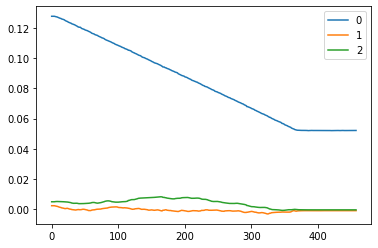

In [27]:
pandas.DataFrame(positions).plot()

In [27]:
txs = []
tys = []
tzs = []
rxs = []
rys = []
rzs = []
fxs = []
fys = []
fzs = []
txs = []
tys = []
tzs = []

for i in range(len(observations_rec)):

    txs.append(observations_rec[i][0])
    tys.append(observations_rec[i][1])
    tzs.append(observations_rec[i][2])
    rxs.append(observations_rec[i][3])
    rys.append(observations_rec[i][4])
    rzs.append(observations_rec[i][5])
    fxs.append(observations_rec[i][6])
    fys.append(observations_rec[i][7])
    fzs.append(observations_rec[i][8])
    txs.append(observations_rec[i][9])
    tys.append(observations_rec[i][10])
    tzs.append(observations_rec[i][11])
    
recordings = {
    "tx" : txs,
    "ty" : tys,
    "tz" : tzs,
    "rx" : rxs,
    "ry" : rys,
    "rz" : rzs,
    "fx" : fxs,
    "fy" : fys,
    "fz" : fzs,
    "tx" : txs,
    "ty" : tys,
    "tz" : tzs,
    "Reward" : rewards_rec
}

In [28]:
filename = "{}".format(take).zfill(4)+"_model_{}.json".format(model_number)
with open(os.path.join(*[SAVE_PATH, filename]), 'w') as file:
    json.dump(recordings, file)
    file.close()

In [28]:
observations_rec_df = pandas.DataFrame(observations_rec, columns=["pos1", "pos2", "pos3", "rotx", "roty", "rotz", "Fx", "Fy", "Fz", "Mx", "My", "Mz"])
poses_rec_df = pandas.DataFrame(poses_rec, columns=["tx", "ty", "tz", "rx", "ry", "rz"])
ft_values_rec_df = pandas.DataFrame(ft_values_rec, columns=["Fx", "Fy", "Fz", "Mx", "My", "Mz"])
q_rec_df = pandas.DataFrame(q_rec, columns=["q[0]", "q[1]", "q[2]", "q[3]", "q[4]", "q[5]"])
qd_rec_df = pandas.DataFrame(qd_rec, columns=["qd[0]", "qd[1]", "qd[2]", "qd[3]", "qd[4]", "qd[5]"])
rewards_df = pandas.DataFrame(rewards_rec, columns=["Rewards"])
info_df = pandas.DataFrame(columns=['Steps', 'Reward'], index=[model_name+"_"+str(take)])

info_df.loc[model_name+"_"+str(take), "Steps"] = len(rewards_rec)
info_df.loc[model_name+"_"+str(take), "Reward"] = numpy.sum(rewards_rec)
    
DIRECTORY = os.path.join(*[SAVE_PATH])
observations_rec_df.to_feather(os.path.join(*[SAVE_PATH, "{}".format(take).zfill(4)+"_obs.ftr"]))
poses_rec_df.to_feather(os.path.join(*[SAVE_PATH, "{}".format(take).zfill(4)+"_pose.ftr"]))
ft_values_rec_df.to_feather(os.path.join(*[SAVE_PATH, "{}".format(take).zfill(4)+"_ft.ftr"]))
q_rec_df.to_feather(os.path.join(*[SAVE_PATH, "{}".format(take).zfill(4)+"_q.ftr"]))
qd_rec_df.to_feather(os.path.join(*[SAVE_PATH, "{}".format(take).zfill(4)+"_qd.ftr"]))
rewards_df.to_feather(os.path.join(*[SAVE_PATH, "{}".format(take).zfill(4)+"_reward.ftr"]))
info_df = info_df.reset_index()
info_df.to_feather(os.path.join(*[SAVE_PATH, "{}".format(take).zfill(4)+"_info.ftr"]))

NameError: name 'model_name' is not defined

# --- Visualize the Data with Visualize_Hardware_Tests.ipynb ---